# Simulating Polarization Dependence

We have a 2-axis simulation over here, and we are going to "rotate" the x and y datasets till we get what we want. Let's see how this is going to work out.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def rotate(x, y, theta):
    # note, this is anti-clockwise rotation
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    # arranging the position as a column vector/matrix
    og_pos_vector = np.array([[x],[y]])
    rot_pos_vector = rot_mat @ og_pos_vector # performing matrix multiplication
    return rot_pos_vector[0, 0], rot_pos_vector[1, 0]

In [3]:
rotate(1,0,np.pi/2)

(6.123233995736766e-17, 1.0)

          t             x             y            vx            vy
0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1  0.000000 -1.858530e-13 -1.656110e-12 -2.775640e-07 -2.002590e-06
2  0.000001  6.735670e-13 -3.987030e-12  1.560730e-06 -8.184380e-07
3  0.000002  1.942730e-12 -5.214480e-13  3.366040e-07  5.008070e-06
4  0.000003  1.348420e-12  4.089740e-12 -1.223760e-06  5.739460e-07


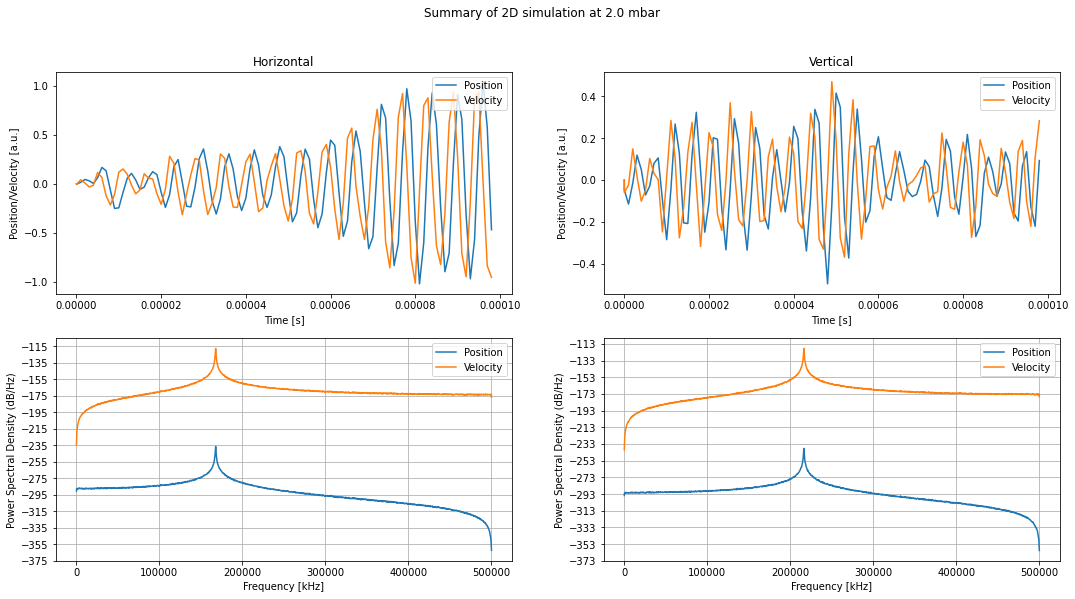

In [17]:
data_dir = "2d-sim.csv"
dataset = pd.read_csv(data_dir) # imported the data
print(dataset.head())

data_stats_2d(dataset, "Summary of 2D simulation at 2.0 mbar", data_dir)

In [35]:
def data_stats_2d(df, title, filename, N=100):
	average_pos_x = np.mean(df.x)
	x_var = np.std(df.x)

	average_pos_y = np.mean(df.y)
	y_var = np.std(df.y)


	fig, axs = plt.subplots(2, 2, figsize=(18,9))
	fig.suptitle(title)
	axs[0][0].set_title("Horizontal")
	axs[0][0].plot(df.t[:N], df.x[:N]/x_var, label="Position")
	axs[0][0].legend(loc="upper right")
	axs[0][0].set_ylabel("Position [a.u.]")
	axs[0][0].set_xlabel("Time [s]")

	axs[1][0].psd(df.x, label="Position", Fs=1e6, NFFT=2**12)
	axs[1][0].legend(loc="upper right")
	axs[1][0].set_xlabel("Frequency [kHz]")
	axs[0][1].set_title("Vertical")

	axs[0][1].plot(df.t[:N], df.y[:N]/y_var, label="Position")
	axs[0][1].legend(loc="upper right")
	axs[0][1].set_ylabel("Position [a.u.]")
	axs[0][1].set_xlabel("Time [s]")

	axs[1][1].psd(df.y, label="Position", Fs=1e6, NFFT=2**12)
	axs[1][1].legend(loc="upper right")
	axs[1][1].set_xlabel("Frequency [kHz]")


	plt.savefig(filename[:-4]+".png")


In [36]:
def rotate_dataset(df, theta):
    pos_data = df[["x", "y"]].to_numpy().T # creating a 2xN matrix of position
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) # rotation angle
    new_pos_data = rot_mat @ pos_data # matrix rotating that array of position vectors
    new_df = pd.DataFrame()
    new_df["t"] = df.t # carrying over the same time signature
    new_df["x"] = new_pos_data[0] # new x-axis data
    new_df["y"] = new_pos_data[1] # new y-axis data
    return new_df
    

In [37]:
rotated_dataset_45 = rotate_dataset(dataset, np.pi/4)

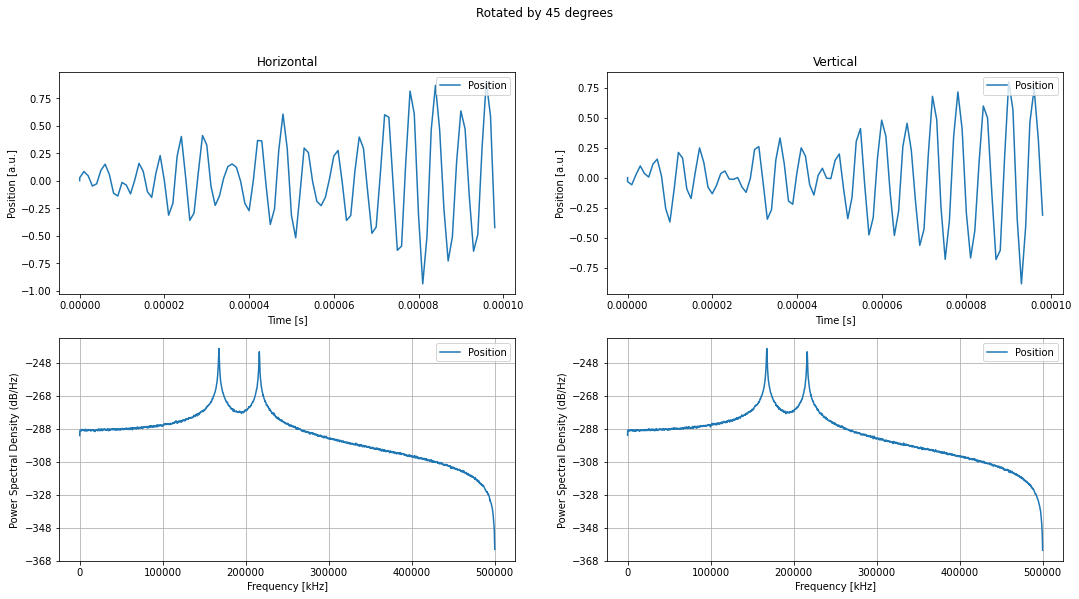

In [38]:
data_stats_2d(rotated_dataset_45, "Rotated by 45 degrees", "rot-45.csv")

In [39]:
# now for the _real_ code

# first, create a dictionary of angles
angles = np.arange(10,100,10)
pol_dataset = { angle : pd.DataFrame() for angle in angles}
for angle in angles:
    pol_dataset[angle] = rotate_dataset(dataset, angle*np.pi/180)


In [40]:
pol_dataset[0] = dataset

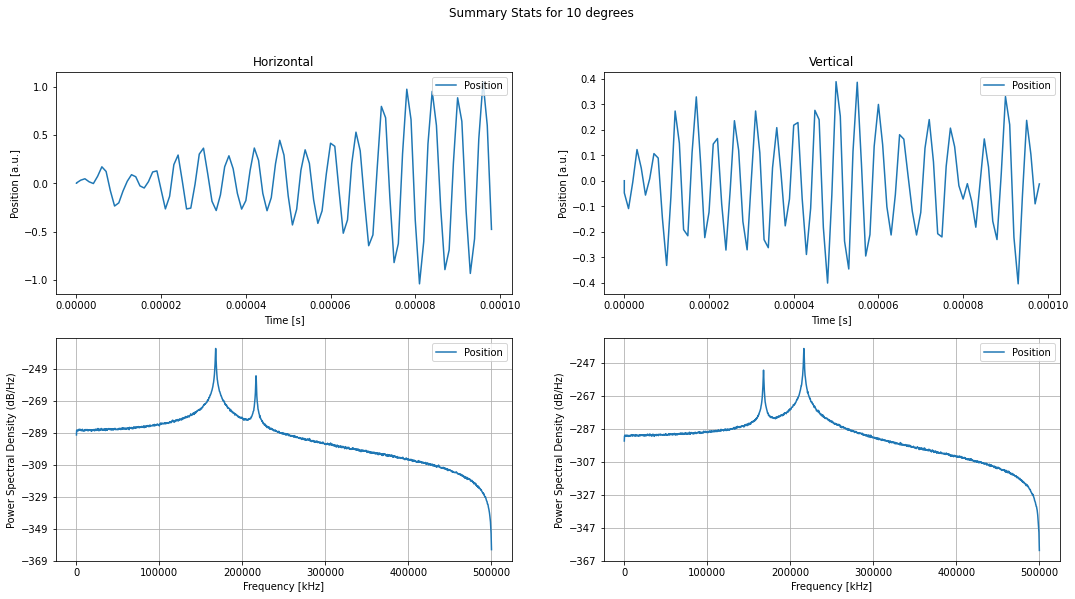

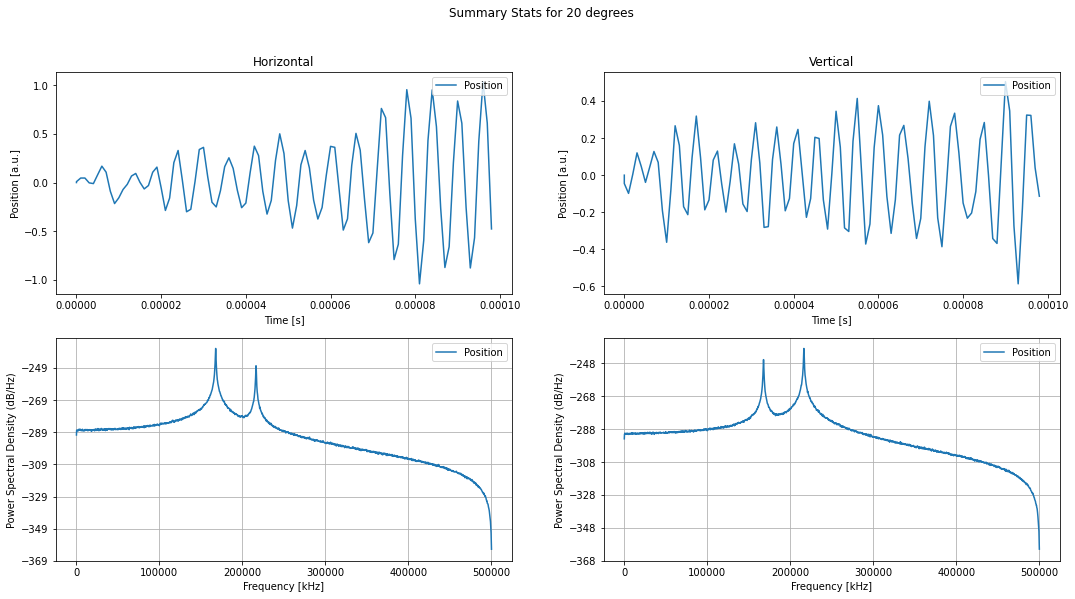

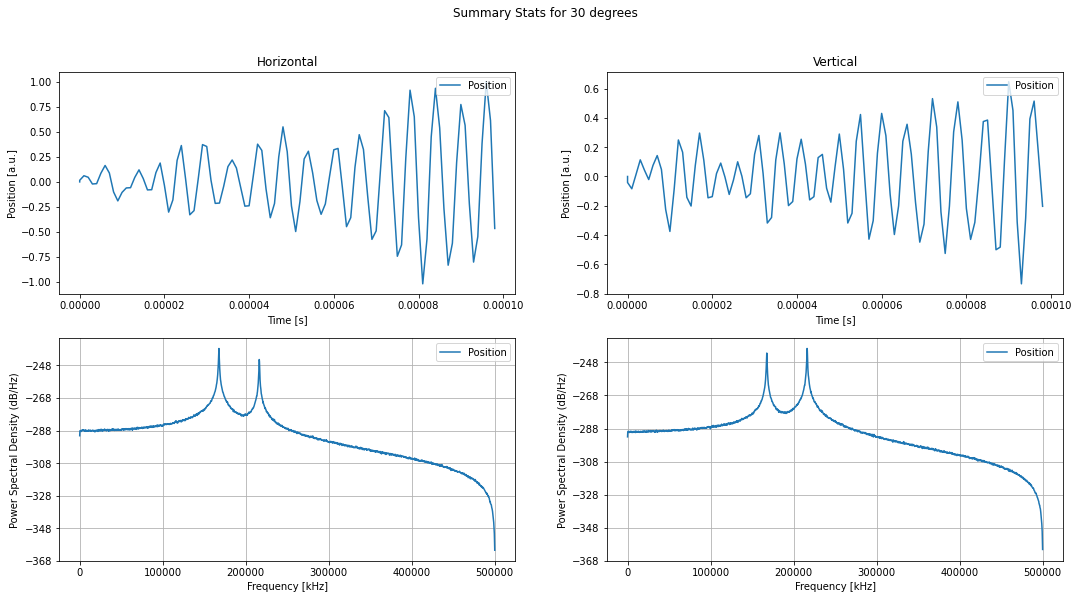

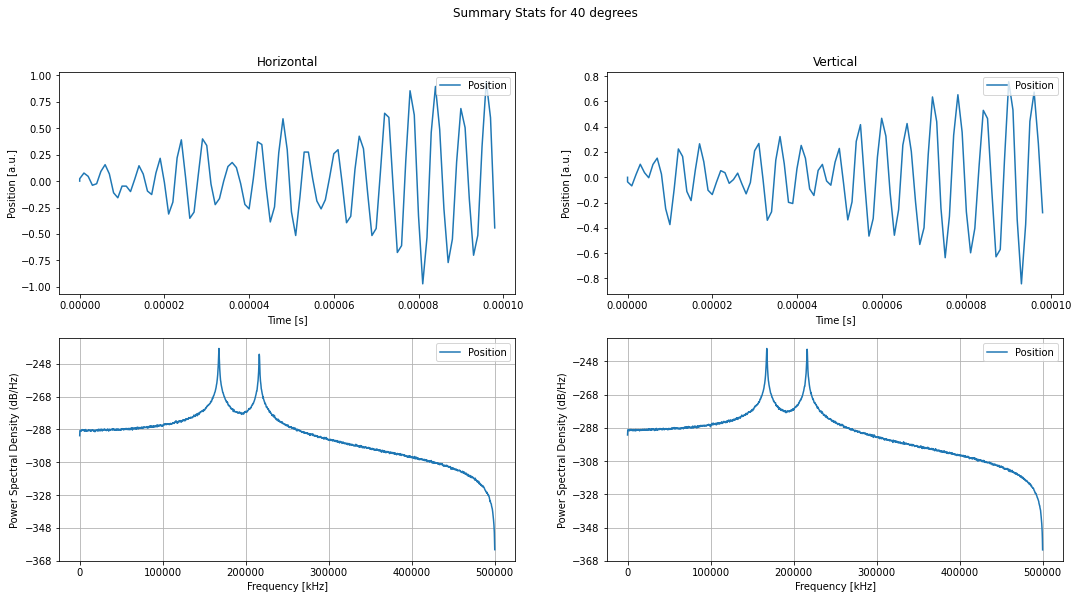

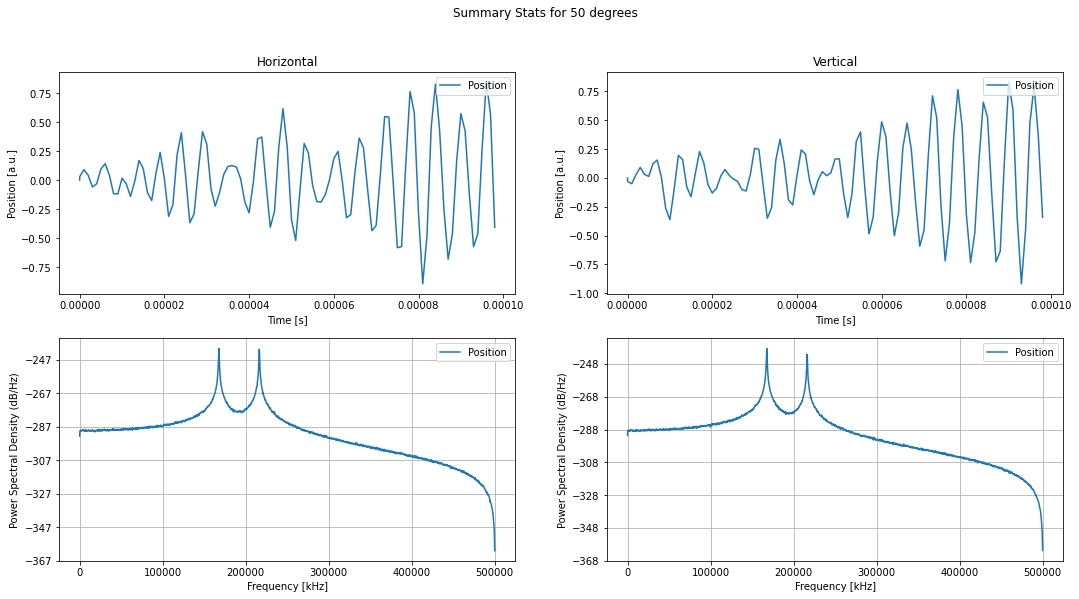

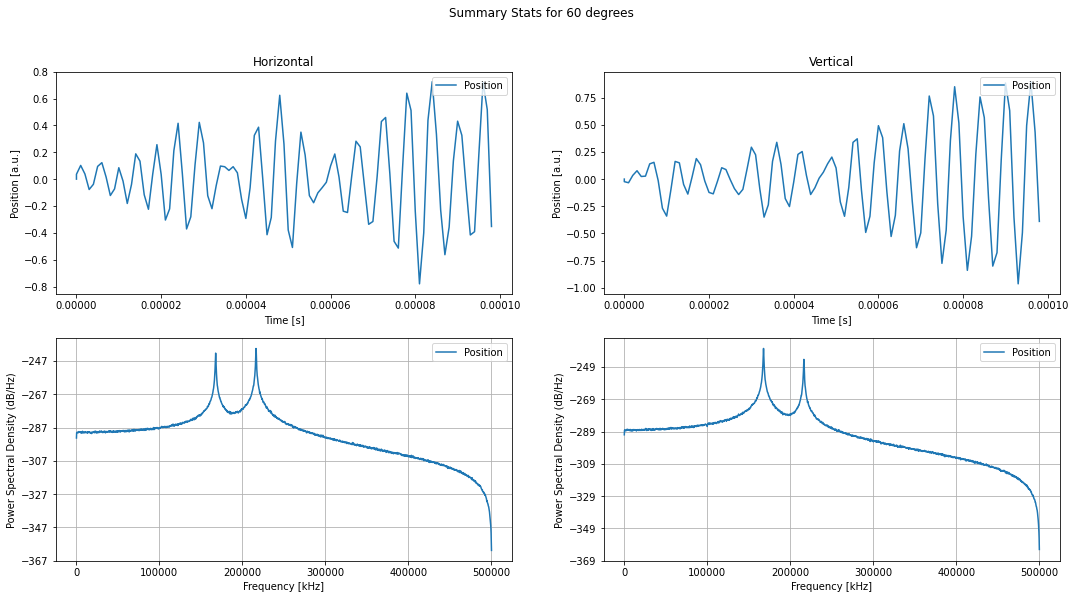

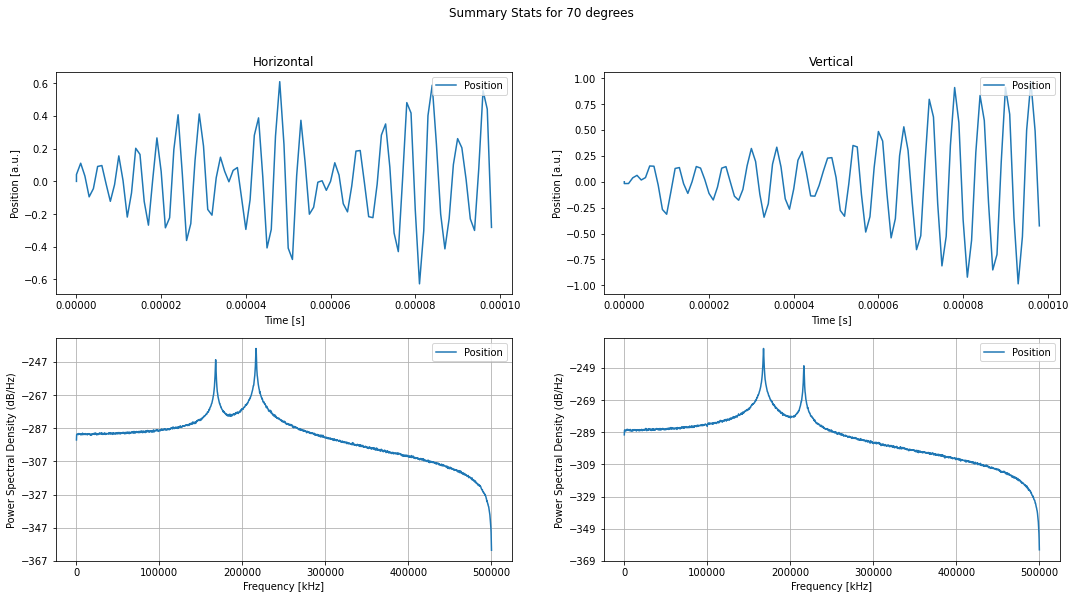

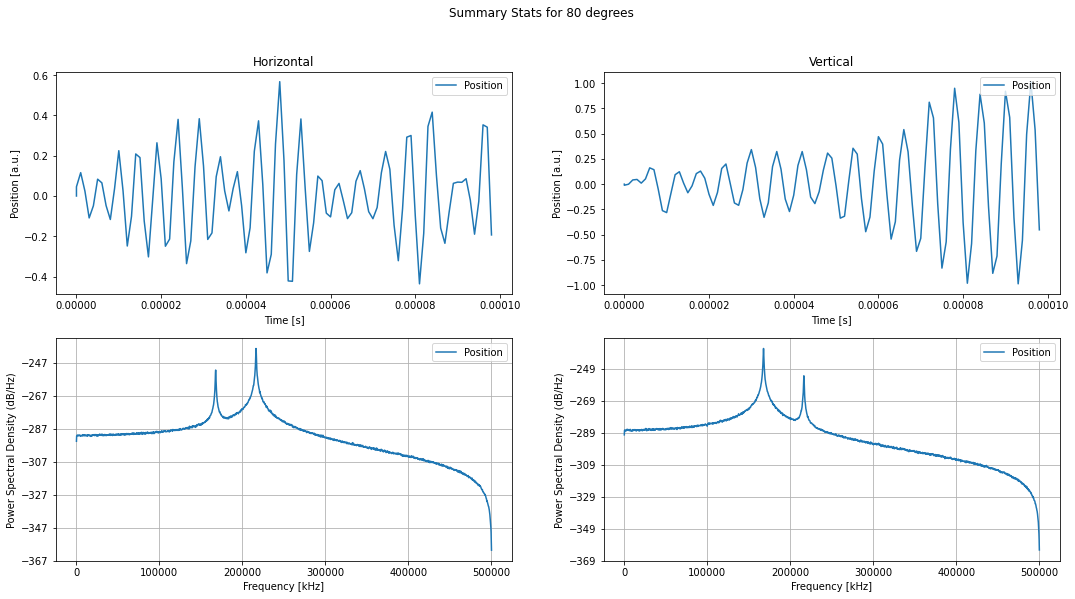

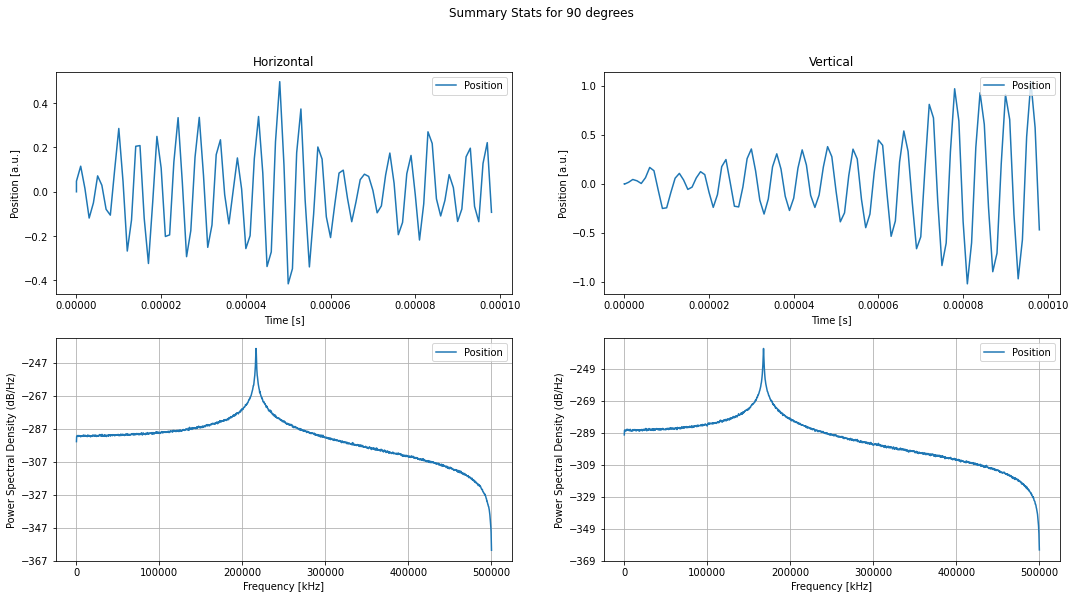

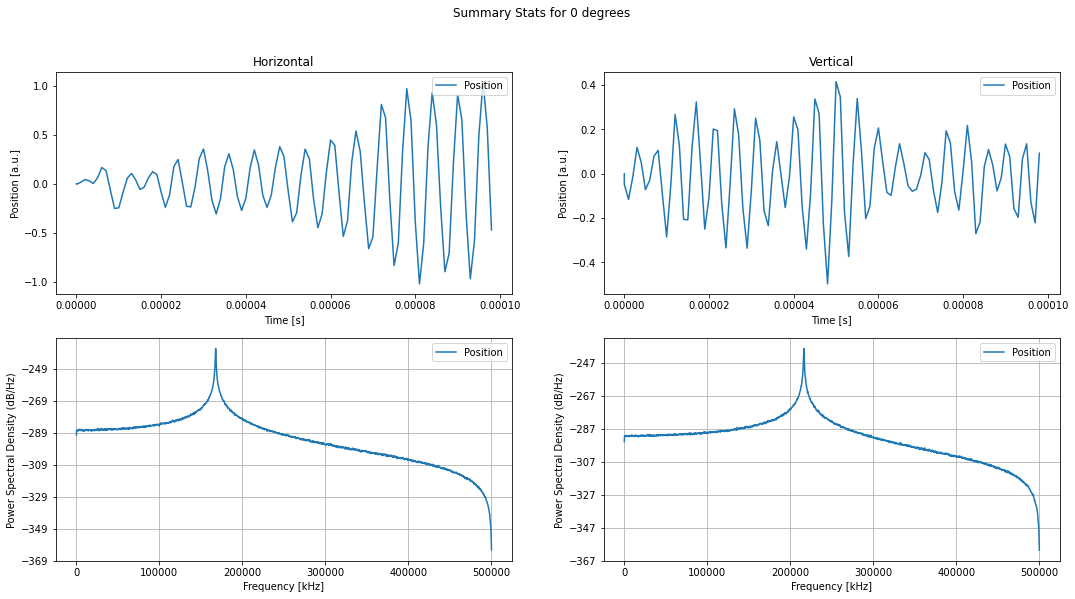

In [41]:
for angle in pol_dataset.keys():
    data_stats_2d(pol_dataset[angle], f"Summary Stats for {angle} degrees", f"2d-data-{angle}-deg.csv")

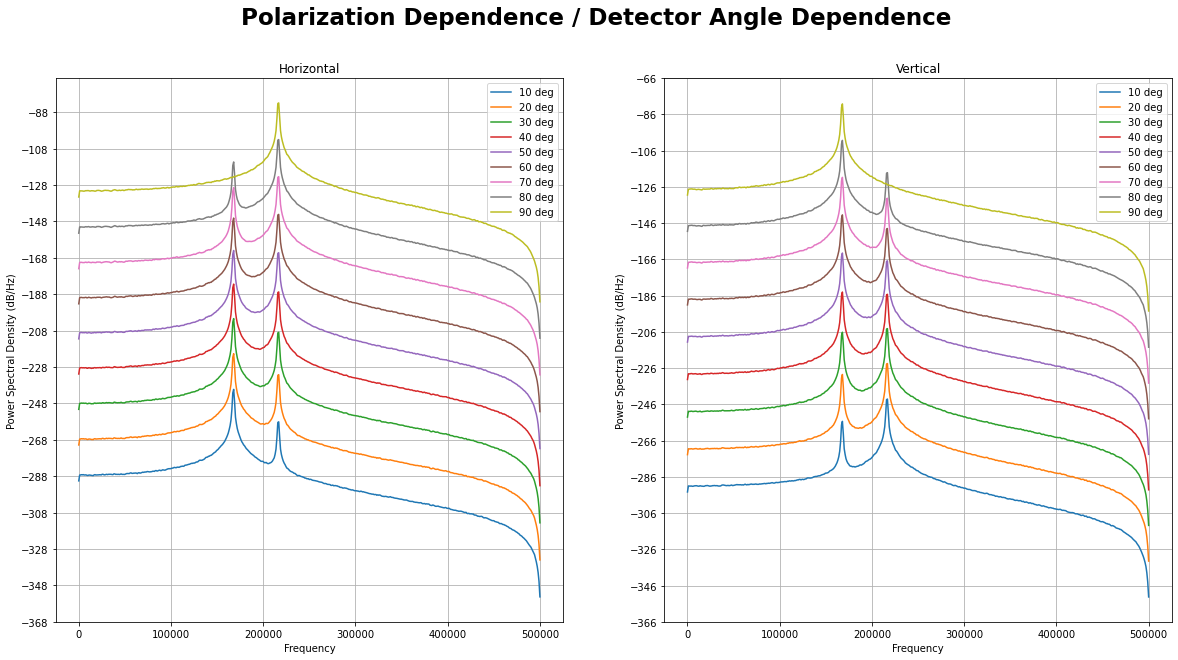

In [49]:
# now, doing the big summary PSD plot
i = 0
fig, axs = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Polarization Dependence / Detector Angle Dependence", fontweight="bold", fontsize=23)
for angle in angles:
    axs[0].psd(10**i * pol_dataset[angle].x, Fs=1e6, NFFT=2**10, label=f"{angle} deg")
    axs[1].psd(10**i * pol_dataset[angle].y, Fs=1e6, NFFT=2**10, label=f"{angle} deg")
    i += 1 
axs[0].legend()
axs[1].legend()
axs[0].set_title("Horizontal")
axs[1].set_title("Vertical")
plt.savefig("polarization-dependence.png")
plt.show()
